In [1]:
import os
from math import pi
import numpy as np
import random
import itertools
import scipy.optimize as opt
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit_aer.noise import NoiseModel
# from qiskit_ibm_provider import IBMProvider
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import utils


from ground_state import get_ground_state, measure_gs_basis_list

In [2]:
shots = 100
epsilon_loss = 1e-3 # loss added if test_counts entry is not found
epsilon_parameters=0.1 # scaling factor for initial random parameters (chosen between 0 to 2pi otherwise)

n_qubits = 3
n_bases = 27
depth = 10

delta = 1.0
h = 1.0
J = 1.0

max_iter = 300

param_name = "theta"

# save checkpoints in case the connection to qpu breaks
# useful for running on real qpu, but not necessary for local simulation
have_checkpoints = False
checkpoint_path = None

trial = 0

bw_list = [0.1]
bw_coeff_list = [10.]

In [3]:
rng = np.random.default_rng()

In [4]:
# backend = AerSimulator()
# sampler = Sampler.from_backend(backend)
# pm = generate_preset_pass_manager(backend=backend)

simulator_ideal = AerSimulator()
# sampler_ideal = Sampler.from_backend(simulator_ideal)
pm_ideal = generate_preset_pass_manager(backend=simulator_ideal, optimization_level=1)

# sampler = sampler_ideal
pm = pm_ideal

In [5]:
def create_ghz_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

def get_circ_for_basis(qc: QuantumCircuit, basis: str):
    circ = qc.copy()
    for i, s in enumerate(basis[::-1]): # here, I am using the same endian convention as qiskit, where the last bit represent the first qubit
        if s == 'Z':
            pass
        elif s == 'X':
            circ.ry(-pi/2, i)
        elif s == 'Y':
            circ.rx(pi/2, i)
        else:
            raise ValueError(f"{s} is invalid basis")

    circ.measure_all()

    return circ

def get_isa_circ_list_for_bases(qc: QuantumCircuit, basis_list, pass_manager):
    circ_list = [get_circ_for_basis(qc, basis) for basis in basis_list]
    isa_circ_list = pass_manager.run(circ_list)
    return isa_circ_list


def measure_isa_circ_list_fs(isa_circ_list, basis_list, shots=shots):
    sampler = Sampler()
    result_list = sampler.run(isa_circ_list, shots=shots).result()
    counts_list = [result.data.meas.get_counts() for result in result_list]
    results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    return results_dic


def get_basis_list(n_bases,n_qubits):
    bases = ["X", "Y", "Z"]
    basis_list = ["".join(p) for p in itertools.product(bases, repeat=n_qubits)]
    culled_basis_list = random.sample(basis_list, n_bases)
    return culled_basis_list




# def measure_circ_for_all_basis(qc, basis_list, shots=total_shots, sampler=None):
#     results_dic = {}
#     qc_list = [get_circ_for_basis(qc, basis, simulator) for basis in basis_list]
#     job = simulator.run(qc_list, shots=shots)
#     result = job.result()
#     counts_list = result.get_counts()
#     results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    
#     return results_dic

In [6]:
basis_list = get_basis_list(n_bases, n_qubits)

In [7]:
gs_state = get_ground_state(n_qubits, delta=delta, h=h, J=J)
gs_measurements = measure_gs_basis_list(n_qubits, basis_list, shots, delta=delta, h=h, J=J)

In [8]:
print(basis_list)

['ZZZ', 'XYY', 'XZY', 'XXX', 'ZXX', 'XXZ', 'ZXY', 'XXY', 'XYZ', 'ZYZ', 'ZYX', 'XZZ', 'YXZ', 'YYZ', 'YYX', 'YZZ', 'YXX', 'YYY', 'ZXZ', 'XZX', 'ZZY', 'YZY', 'ZZX', 'XYX', 'ZYY', 'YZX', 'YXY']


In [9]:
print(gs_measurements)

{'ZZZ': {'011': 17, '101': 68, '110': 15}, 'XYY': {'000': 2, '001': 23, '010': 22, '011': 7, '100': 2, '101': 13, '110': 27, '111': 4}, 'XZY': {'000': 15, '001': 20, '010': 11, '011': 5, '100': 20, '101': 16, '110': 7, '111': 6}, 'XXX': {'001': 9, '010': 33, '011': 8, '100': 11, '101': 33, '110': 6}, 'ZXX': {'000': 7, '001': 2, '010': 2, '011': 1, '100': 1, '101': 43, '110': 39, '111': 5}, 'XXZ': {'000': 2, '001': 5, '010': 5, '011': 38, '100': 3, '101': 35, '110': 6, '111': 6}, 'ZXY': {'000': 6, '001': 5, '010': 5, '100': 15, '101': 22, '110': 20, '111': 27}, 'XXY': {'000': 2, '001': 4, '010': 22, '011': 19, '100': 25, '101': 20, '110': 1, '111': 7}, 'XYZ': {'000': 4, '001': 24, '010': 6, '011': 19, '100': 6, '101': 14, '110': 3, '111': 24}, 'ZYZ': {'001': 9, '011': 8, '100': 9, '101': 28, '110': 13, '111': 33}, 'ZYX': {'000': 5, '001': 3, '010': 7, '011': 3, '100': 25, '101': 12, '110': 21, '111': 24}, 'XZZ': {'001': 34, '010': 9, '011': 11, '101': 29, '110': 9, '111': 8}, 'YXZ': {'0

In [10]:
def initialize_theta_random(circ_depth=10, num_qbits=3):
    """
    Initialize the theta parameter vector
    :param circ_depth: int, number of parameterized layers in circuit
    :param num_qbits: int, number of qbits
    :return: np.array, values of theta
    """

    theta = rng.random(size=(circ_depth, num_qbits))
    theta = 2*pi*epsilon_parameters*theta
    return theta

In [11]:
def construct_variational_circ_ansatz(num_qbits, circ_depth, param_name = param_name):
    """
    Generate a parameterized variational quantum circuit
    
    """

    num_parameters = num_qbits * circ_depth
    theta_vec = ParameterVector(param_name, length=num_parameters)
    var_circ = QuantumCircuit(num_qbits)


    for layer in range(circ_depth - 1):
        # Compute if layer is odd or even to apply rx or ry gate to circuit
        is_odd_step = (layer + 1) % 2

        for qbit in range(num_qbits):
            if is_odd_step:
                var_circ.rx(theta_vec[layer * num_qbits + qbit], qbit)
            else:
                var_circ.ry(theta_vec[layer * num_qbits + qbit], qbit)

        # Apply CX gates
        for qbit in range((1-is_odd_step), num_qbits-1, 2):
            # isOddStep may subtract 1 if True, to correctly apply cx gate location
            var_circ.cx(qbit , qbit + 1)
            var_circ.barrier() # for visualization only

    for qbit in range(num_qbits):  # bonus layer at the end only has rx gates and no cx
        var_circ.rx(theta_vec[(circ_depth - 1) * num_qbits + qbit], qbit)

    return var_circ, theta_vec


In [12]:
ansatz, param_vec = construct_variational_circ_ansatz(n_qubits, depth, param_name=param_name)

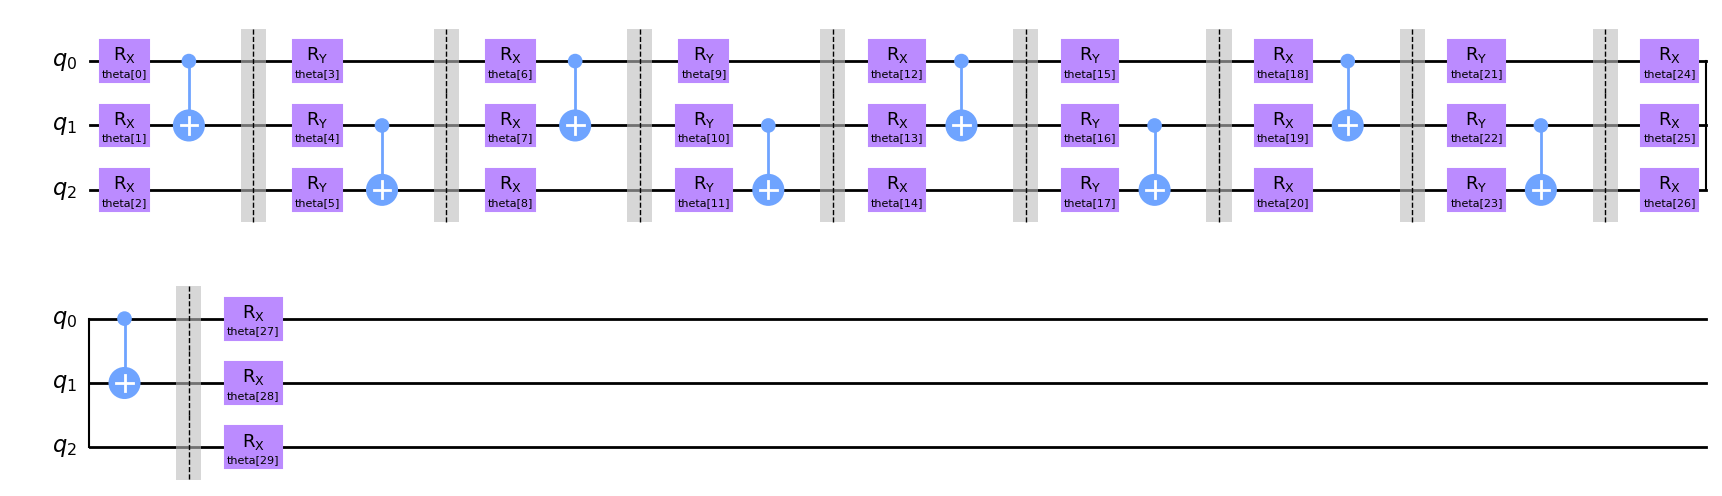

In [13]:
ansatz.draw(output="mpl", style="clifford")

In [14]:
ansatz_isa_list = get_isa_circ_list_for_bases(ansatz, basis_list, pm)

In [15]:
def get_ansatz_output(ansatz_isa_list, parameters, basis_list, shots, param_placeholder=param_vec):
    circ_run_list = [circ.assign_parameters({param_placeholder:parameters}) for circ in ansatz_isa_list]
    return measure_isa_circ_list_fs(isa_circ_list=circ_run_list, basis_list=basis_list, shots=shots)

In [16]:
def string_to_arr(string):
    """Convert a bit string of 0 and 1 to an array of 0 and 1"""
    return [int(c) for c in string]

def kernel(arr, bw_list, coeff_list=None):
    assert np.ndim(arr) == 2
    assert len(bw_list) == len(coeff_list)

    n_datapoints, n_qubits = arr.shape

    diff_mat = np.expand_dims(arr, axis=0) - np.expand_dims(arr, axis=1)
    diff2 = np.sum(diff_mat**2, axis=-1) 

    result_mat = np.zeros((n_datapoints,n_datapoints))
    for (bw, coeff) in zip(bw_list, coeff_list):
        result_mat += coeff * np.exp(-0.5 * diff2 / bw)
    
    return result_mat

def mmd_for_one_basis(dict1, dict2, bw_list, coeff_list=None):
    outcomes1 = dict1.keys()
    outcomes2 = dict2.keys()
    outcome_strings = list(set(outcomes1).union(set(outcomes2)))
    outcome_arr = np.array([string_to_arr(string) for string in outcome_strings])

    kernel_matrix = kernel(outcome_arr, bw_list, coeff_list)

    vec_1 = np.array([dict1.get(string, 0) for string in outcome_strings])
    vec_2 = np.array([dict2.get(string, 0) for string in outcome_strings])

    vec_1 = vec_1 / np.sum(vec_1)
    vec_2 = vec_2 / np.sum(vec_2)

    return vec_1 @ kernel_matrix @ vec_1 + vec_2 @ kernel_matrix @ vec_2 - 2 * vec_1 @ kernel_matrix @ vec_2



def mmd_loss(true_data, test_data, bw_list, coeff_list=None):
    loss = 0.

    if coeff_list is None:
        coeff_list = np.ones(len(bw_list))
    elif np.ndim(coeff_list) == 0:
        coeff_list = np.ones(len(bw_list)) * coeff_list
    else:
        assert len(bw_list) == len(coeff_list)

    for basis in true_data:
        loss += mmd_for_one_basis(true_data[basis], test_data[basis], bw_list, coeff_list)
        
    return loss / len(true_data)
    

In [17]:
global loss_values
global thetas

loss_values = []
thetas = []

In [18]:
def compute_loss_mmd(theta_vector, ansatz_isa_list,  basis_list, true_data, total_shots, param_placeholder=param_vec, \
        have_checkpoints=have_checkpoints, checkpoint_path=checkpoint_path, bw_list = bw_list, bw_coeff_list = bw_coeff_list):
    # theta = np.reshape(theta_vector, (circ_depth, num_qbits))
    # tempcirc = construct_variational_circ(theta=theta)
    test_data = get_ansatz_output(ansatz_isa_list=ansatz_isa_list, parameters=theta_vector, basis_list=basis_list, \
        shots=total_shots, param_placeholder=param_placeholder)
    # test_data = measure_circ_for_all_basis(qc = tempcirc, basis_list=basis_list, simulator=simulator)
    loss = mmd_loss(true_data, test_data, bw_list, coeff_list=bw_coeff_list)

    global loss_values
    global thetas 
    loss_values.append(loss)
    thetas.append(theta_vector)

    num_iter = len(loss_values)

    print(f"Iteration {num_iter:5}; current loss is {loss}")

    if have_checkpoints:
        # save checkpoints in case the connection to qpu breaks
        # useful for running on real qpu, but not necessary for local simulation
        np.save(os.path.join(checkpoint_path, f"theta_iter{num_iter}.npy"), thetas)
    
    return loss

In [19]:
# wraps the function with the all arguments but theta vector already filled

def compute_loss_filled(theta_vector):
    return compute_loss_mmd(theta_vector, ansatz_isa_list, basis_list, gs_measurements, shots, param_vec)


In [20]:
%%time

theta = initialize_theta_random(circ_depth=depth, num_qbits = n_qubits)
theta_vector = np.reshape(theta, theta.size)
circ_depth, num_qbits = theta.shape

spsa = SPSA(maxiter=max_iter)
c=0.1258
A=0.3186
a1=0.4739
alpha=0.6374
gamma=0.06059
(lr, p) = spsa.calibrate(compute_loss_filled, theta_vector, c=c, stability_constant = A, target_magnitude=a1, alpha=alpha, gamma=gamma)
spsa.learning_rate = lr
spsa.perturbation = p

# args = (ansatz_isa_list, basis_list, GHZ_measurement, shots, param_vec)

# results = opt.minimize(compute_kl_loss, theta_vector, args = args, method = "Powell", options={"maxiter":max_iter})

results = spsa.minimize(compute_loss_filled, theta_vector)

Iteration     1; current loss is 1.9103398679447996
Iteration     2; current loss is 2.3070847328096695
Iteration     3; current loss is 2.0194932417031897
Iteration     4; current loss is 2.2196661652109815
Iteration     5; current loss is 2.2642614965356564
Iteration     6; current loss is 1.9538747501897906
Iteration     7; current loss is 2.057771133098641
Iteration     8; current loss is 1.9878491609956441
Iteration     9; current loss is 2.129924806998463
Iteration    10; current loss is 1.9116575977739703
Iteration    11; current loss is 2.0931380272401543
Iteration    12; current loss is 1.9461243399774986
Iteration    13; current loss is 2.1557761620200435
Iteration    14; current loss is 1.9921579036915928
Iteration    15; current loss is 2.4135673084748817
Iteration    16; current loss is 1.8643138378085242
Iteration    17; current loss is 2.0542810931629134
Iteration    18; current loss is 1.805058008610216
Iteration    19; current loss is 2.099973824429247
Iteration    20;

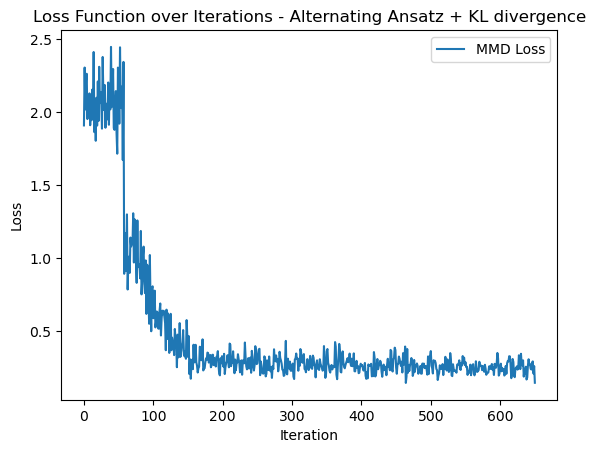

In [21]:
fig, ax = plt.subplots()
ax.plot(loss_values, label=f"MMD Loss")
# plt.ylim(0, 30)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title(f"Loss Function over Iterations - Alternating Ansatz + KL divergence")
ax.legend()

# fig.savefig("loss_curve.png")

In [22]:
def compute_fidelity(psi, phi):
    """
    Compute the fidelity (a measure of similarity) between the two states
    :param psi: qiskit.Statevector, our target state |psi>
    :param phi: qiskit.Statevector, our estimated state |phi>
    :return: float, fidelity
    """

    fidelity = qiskit.quantum_info.state_fidelity(psi, phi)
    print(f"psi: {psi}, phi: {phi}")
    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # plot_bloch_multivector(psi)
    # axes[0].set_title("psi")
    # plot_bloch_multivector(phi)
    # axes[1].set_title("phi")
    return fidelity



ansatz_state = Statevector.from_instruction(ansatz.assign_parameters({param_vec : results.x}))

final_fidelity = qiskit.quantum_info.state_fidelity(gs_state, ansatz_state)

In [23]:
print(f"target state: {gs_state}\nansatz: {ansatz_state}")

target state: Statevector([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
             -0.40824829+0.j,  0.        +0.j,  0.81649658+0.j,
             -0.40824829+0.j,  0.        +0.j],
            dims=(2, 2, 2))
ansatz: Statevector([-0.01800435+0.03333819j, -0.01315425-0.00181818j,
             -0.02283126+0.02186201j, -0.20404099-0.33301273j,
              0.01270593-0.00799082j,  0.45882174+0.67517147j,
             -0.21975214-0.35914268j, -0.00164907-0.03134119j],
            dims=(2, 2, 2))


In [24]:
print(final_fidelity)

0.9952086107932258


In [25]:
print(results.x)

[-0.51905992  1.0638867   0.19313529  0.06292414 -0.27262333  2.31266698
  1.26454947 -0.03809107 -0.6801587   1.0295783  -1.60873085 -0.32459373
  0.24685752  0.62597915  0.65145521 -1.31158317  0.05021269  2.4753198
  0.78293794 -0.50599798  1.35201462 -0.24136282  0.79165536  1.78766613
 -0.93648694  0.28263111 -0.25657515 -1.47482828 -1.82222994  0.28923284]


In [26]:
np.save(f"saved/params_training_s{trial}.npy", thetas)
np.save(f"saved/loss_training_s{trial}.npy", loss_values)
np.save(f"saved/final_theta_s{trial}.npy", results.x)
np.save(f"saved/fidelity_s{trial}.npy", final_fidelity)